# **IMPORT LIBRARIES**

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.0+cu126
False


In [4]:
!pip install torch_geometric
!pip install optuna
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.nn import GCNConv, BatchNorm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import optuna
import random


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


# **DATA UPLOAD**

In [5]:
# ==========================================================
# 1. SEED FOR REPRODUCIBILITY
# ==========================================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [8]:
# 2. LOAD CSV FILES (YOUR GIVEN LOCATION)
# ==========================================================
feat_path   = r"/content/best5_features.csv"
edges_path  = r"/content/facebook_edges.csv"
target_path = r"/content/encoded_facebook_target.csv"

feat   = pd.read_csv(feat_path)
edges  = pd.read_csv(edges_path)
target = pd.read_csv(target_path)

# Initialize and fit LabelEncoder to get class names
le = LabelEncoder()
le.fit(target['page_type'])

print("Shapes -> features:", feat.shape,
      " | edges:", edges.shape,
      " | target:", target.shape)

Shapes -> features: (22470, 5)  | edges: (171002, 2)  | target: (22470, 2)


In [9]:
# Sanity check
assert len(feat) == len(target), "Features and target must have same number of rows!"

In [10]:
# 4. BUILD EDGE INDEX
#    (ids in facebook_edges.csv are assumed 0..num_nodes-1)
# ==========================================================
num_nodes = len(feat)
edge_index = torch.tensor(
    edges[["id_1", "id_2"]].values,
    dtype=torch.long
).t().contiguous()

# Filter invalid edges (just in case)
mask = (
    (edge_index[0] >= 0) & (edge_index[0] < num_nodes) &
    (edge_index[1] >= 0) & (edge_index[1] < num_nodes)
)
edge_index = edge_index[:, mask]

# Make graph undirected
edge_index = to_undirected(edge_index, num_nodes=num_nodes)

print("edge_index shape:", edge_index.shape)


edge_index shape: torch.Size([2, 341825])


# **TENSOR CREATION**

In [11]:
# 5. CREATE PYTORCH GEOMETRIC DATA OBJECT
# ==========================================================
X = torch.tensor(feat.values, dtype=torch.float)
y = torch.tensor(target['page_type_encoded'].values, dtype=torch.long)
data = Data(x=X, edge_index=edge_index, y=y)
print(data)

Data(x=[22470, 5], edge_index=[2, 341825], y=[22470])


In [12]:
# 6. DEVICE + CLASS WEIGHTS
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)

data = data.to(device)

labels_np = data.y.cpu().numpy()
classes   = np.unique(labels_np)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=labels_np
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float, device=device)
print("Class weights:", class_weights)


Using device: cpu
Class weights: tensor([0.8649, 0.8165, 0.9739, 1.6885])


In [13]:
# 7. TRAIN / VAL / TEST SPLIT (NODE LEVEL)
# ==========================================================

seed = 42   # <<< ADD THIS LINE

indices = np.arange(num_nodes)

train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    labels_np,
    test_size=0.3,
    stratify=labels_np,
    random_state=seed
)

val_idx, test_idx, _, _ = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=seed
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool, device=device)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool, device=device)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

print(f"\nTrain nodes: {train_mask.sum().item()}, "
      f"Val nodes: {val_mask.sum().item()}, "
      f"Test nodes: {test_mask.sum().item()}")


Train nodes: 15729, Val nodes: 3370, Test nodes: 3371


# **GRAPH CONVOLUTION NETWORK MODEL CREATION**

In [14]:
# 8. DEFINE GCN MODEL + TRAIN / EVAL FUNCTIONS
# ==========================================================
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1   = BatchNorm(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2   = BatchNorm(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return x

def train_one_epoch(model, data, train_mask, optimizer, class_weights):
    model.train()
    optimizer.zero_grad()
    out  = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask],
                           weight=class_weights)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = out.argmax(dim=-1)
        acc  = (pred[train_mask] == data.y[train_mask]).float().mean().item()
    return loss.item(), acc

@torch.no_grad()
def eval_on_mask(model, data, mask, class_weights):
    model.eval()
    out  = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[mask], data.y[mask],
                           weight=class_weights)
    pred = out.argmax(dim=-1)
    acc  = (pred[mask] == data.y[mask]).float().mean().item()
    return loss.item(), acc


# **HYPERPARAMETER TUNNING USING OPTUNA**

In [ ]:
# 9. OPTUNA HYPERPARAMETER TUNING
# ==========================================================
num_features = data.x.shape[1]
num_classes  = data.y.max().item() + 1 # Assuming labels are 0-indexed

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 256, step=32)
    dropout         = trial.suggest_float("dropout", 0.2, 0.7)
    lr              = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay    = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    model = GCN(num_features, hidden_channels, num_classes, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                 weight_decay=weight_decay)

    epochs   = 80         # per trial
    patience = 15
    best_val_acc = 0.0
    no_improve   = 0

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, data, train_mask,
                                          optimizer, class_weights)
        va_loss, va_acc = eval_on_mask(model, data, val_mask, class_weights)

        if va_acc > best_val_acc + 1e-4:
            best_val_acc = va_acc
            no_improve   = 0
        else:
            no_improve += 1

        # Optional: report to Optuna for pruning (not using pruner here)
        trial.report(va_acc, epoch)

        if no_improve >= patience:
            break

    return best_val_acc

print("\n=== Starting Optuna study ===")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\nBest trial:")
print("  Value (val acc):", study.best_value)
print("  Params:", study.best_params)

best_params = study.best_params
best_hidden   = best_params["hidden_channels"]
best_dropout  = best_params["dropout"]
best_lr       = best_params["lr"]
best_wd       = best_params["weight_decay"]

[I 2025-12-05 15:20:47,854] A new study created in memory with name: no-name-da825d8d-d0bb-4fa5-9833-599395989819



=== Starting Optuna study ===


[I 2025-12-05 15:21:31,768] Trial 0 finished with value: 0.27091988921165466 and parameters: {'hidden_channels': 160, 'dropout': 0.6189403895575132, 'lr': 0.000378499419694816, 'weight_decay': 3.775342117867886e-06}. Best is trial 0 with value: 0.27091988921165466.
[I 2025-12-05 15:23:18,967] Trial 1 finished with value: 0.6142433285713196 and parameters: {'hidden_channels': 64, 'dropout': 0.37436365088594603, 'lr': 0.0023139811808230272, 'weight_decay': 9.853165982163791e-06}. Best is trial 1 with value: 0.6142433285713196.
[I 2025-12-05 15:24:59,146] Trial 2 finished with value: 0.5516320466995239 and parameters: {'hidden_channels': 64, 'dropout': 0.6979553259091283, 'lr': 0.0018411044094263427, 'weight_decay': 2.000857851376693e-05}. Best is trial 1 with value: 0.6142433285713196.
[I 2025-12-05 15:28:34,371] Trial 3 finished with value: 0.602967381477356 and parameters: {'hidden_channels': 160, 'dropout': 0.25130651152321243, 'lr': 0.0003377154373178753, 'weight_decay': 0.0001594305


Best trial:
  Value (val acc): 0.6338278651237488
  Params: {'hidden_channels': 192, 'dropout': 0.21797897962452348, 'lr': 0.0007103722653847239, 'weight_decay': 4.655882279659582e-05}


# **MODEL TRAINING**

In [26]:
# 10. TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS
#     (OPTIONALLY USE TRAIN + VAL TOGETHER)
# ==========================================================
train_val_mask = train_mask | val_mask

# Set the best hyperparameters directly as requested
best_hidden   = 192
best_dropout  = 0.21797897962452348
best_lr       = 0.0007103722653847239
best_wd       = 4.655882279659582e-05

model = GCN(num_features, best_hidden, num_classes, best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr,
                             weight_decay=best_wd)

epochs   = 400
patience = 30

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

best_val_acc = 0.0
best_state   = None
no_improve   = 0

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, data, train_val_mask,
                                      optimizer, class_weights)
    va_loss, va_acc = eval_on_mask(model, data, val_mask, class_weights)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    if va_acc > best_val_acc + 1e-4:
        best_val_acc = va_acc
        best_state   = model.state_dict()
        no_improve   = 0
    else:
        no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | "
              f"Train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"Val loss {va_loss:.4f} acc {va_acc:.3f}")

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 010 | Train loss 1.1637 acc 0.517 | Val loss 1.3608 acc 0.351
Epoch 020 | Train loss 1.0857 acc 0.586 | Val loss 1.3841 acc 0.351
Epoch 030 | Train loss 1.0498 acc 0.604 | Val loss 1.3086 acc 0.425
Epoch 040 | Train loss 1.0213 acc 0.618 | Val loss 1.1832 acc 0.505
Epoch 050 | Train loss 1.0024 acc 0.627 | Val loss 1.0803 acc 0.576
Epoch 060 | Train loss 0.9841 acc 0.642 | Val loss 1.0164 acc 0.621
Epoch 070 | Train loss 0.9694 acc 0.644 | Val loss 0.9857 acc 0.638
Epoch 080 | Train loss 0.9567 acc 0.651 | Val loss 0.9675 acc 0.645
Epoch 090 | Train loss 0.9484 acc 0.659 | Val loss 0.9490 acc 0.651
Epoch 100 | Train loss 0.9305 acc 0.667 | Val loss 0.9369 acc 0.660
Epoch 110 | Train loss 0.9233 acc 0.665 | Val loss 0.9274 acc 0.665
Epoch 120 | Train loss 0.9119 acc 0.669 | Val loss 0.9149 acc 0.668
Epoch 130 | Train loss 0.9054 acc 0.678 | Val loss 0.9061 acc 0.677
Epoch 140 | Train loss 0.8871 acc 0.684 | Val loss 0.8995 acc 0.679
Epoch 150 | Train loss 0.8862 acc 0.684 | Val lo

# **MODEL TESTING RESULTS**

## **TEST ACCURACY**

In [27]:
# 11. TEST EVALUATION
# ==========================================================
test_loss, test_acc = eval_on_mask(model, data, test_mask, class_weights)
print(f"\nFINAL TEST | loss: {test_loss:.4f}, acc: {test_acc:.3f}")


FINAL TEST | loss: 0.7845, acc: 0.726


## **TRAIN VS CROSS VAL LOSS CURVE**

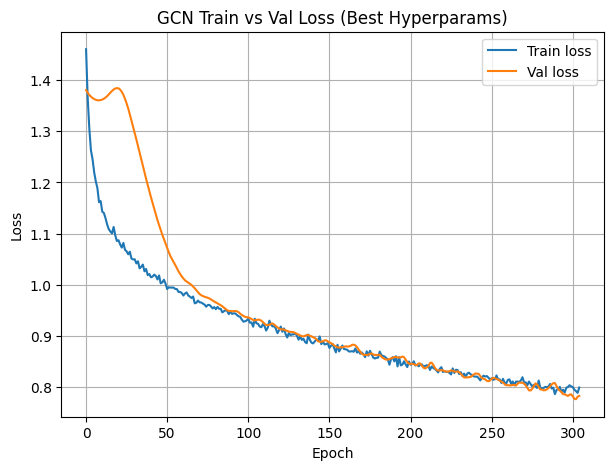

In [28]:
# 12. PLOTS: LOSS & ACCURACY vs EPOCH
# ==========================================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Train vs Val Loss (Best Hyperparams)")
plt.legend()
plt.grid(True)
plt.show()


## **TRAIN VS CROSS VAL ACCURACY CURVE**

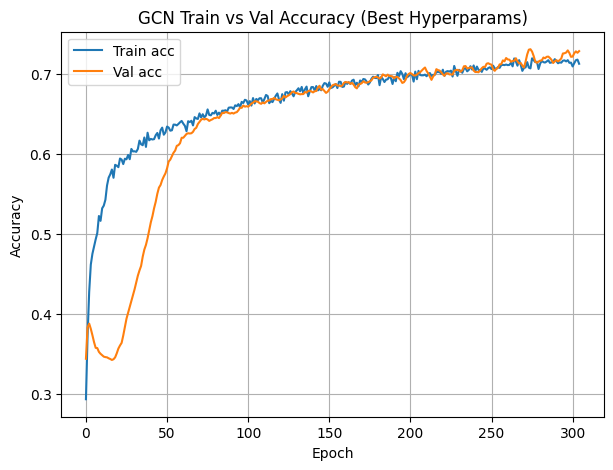

In [29]:
plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train acc")
plt.plot(val_accs,   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN Train vs Val Accuracy (Best Hyperparams)")
plt.legend()
plt.grid(True)
plt.show()


## **CONFUSION MATRIX & PROJECT REPORT**


Confusion Matrix:
[[636 120  98 121]
 [ 34 908  79  11]
 [ 70 102 648  45]
 [ 82  63  98 256]]

Classification Report:
              precision    recall  f1-score   support

     company       0.77      0.65      0.71       975
  government       0.76      0.88      0.82      1032
  politician       0.70      0.75      0.72       865
      tvshow       0.59      0.51      0.55       499

    accuracy                           0.73      3371
   macro avg       0.71      0.70      0.70      3371
weighted avg       0.72      0.73      0.72      3371



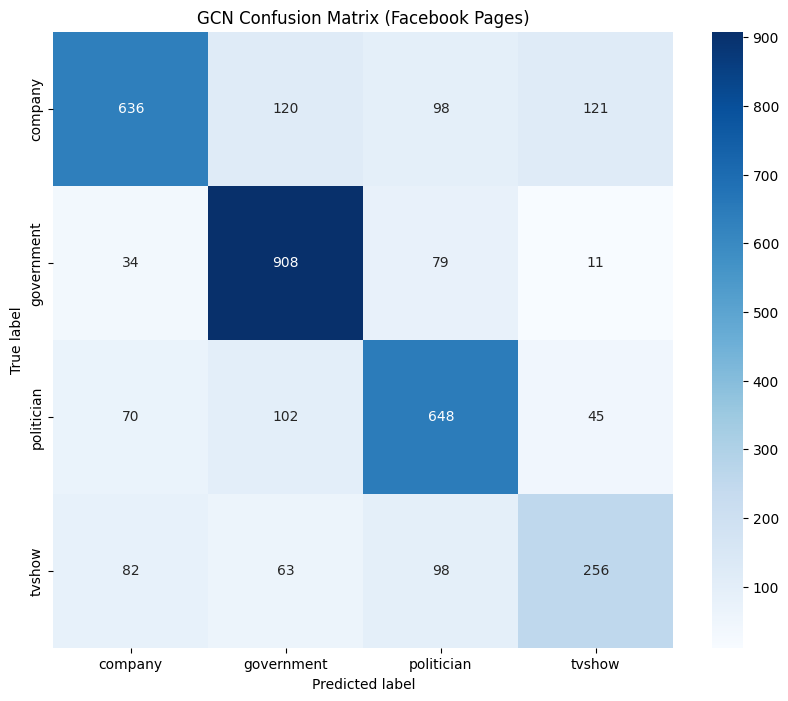

In [30]:
# 13. CONFUSION MATRIX & CLASSIFICATION REPORT
# ==========================================================
model.eval()
with torch.no_grad():
    out   = model(data.x, data.edge_index)
    preds = out.argmax(dim=1).cpu().numpy()
    true  = data.y.cpu().numpy()

test_mask_np = test_mask.cpu().numpy()
test_preds   = preds[test_mask_np]
test_true    = true[test_mask_np]

cm = confusion_matrix(test_true, test_preds)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(test_true, test_preds,
                            target_names=le.classes_))

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("GCN Confusion Matrix (Facebook Pages)")
plt.show()

# **GRAPH VISUALISATION**

In [31]:
import networkx as nx

# Convert edge_index to NetworkX graph
edges_list = data.edge_index.t().cpu().numpy().tolist()
G = nx.from_edgelist(edges_list, create_using=nx.Graph) # Create undirected graph

# Retrieve true labels (numeric)
true_labels_numeric = data.y.cpu().numpy()

# Retrieve predicted labels (numeric)
predicted_labels_numeric = preds # 'preds' is already a numpy array from previous cell

# Retrieve test mask
test_nodes_mask_np = test_mask.cpu().numpy()

# Map true numeric labels back to original page_type names
true_labels_str = le.inverse_transform(true_labels_numeric)

# Map predicted numeric labels back to original page_type names
predicted_labels_str = le.inverse_transform(predicted_labels_numeric)

print("NetworkX graph created with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges.")
print("Shape of true_labels_numeric:", true_labels_numeric.shape)
print("Shape of predicted_labels_numeric:", predicted_labels_numeric.shape)
print("Shape of test_nodes_mask_np:", test_nodes_mask_np.shape)
print("Example true_labels_str (first 5):", true_labels_str[:5])
print("Example predicted_labels_str (first 5):", predicted_labels_str[:5])

NetworkX graph created with 22470 nodes and 171002 edges.
Shape of true_labels_numeric: (22470,)
Shape of predicted_labels_numeric: (22470,)
Shape of test_nodes_mask_np: (22470,)
Example true_labels_str (first 5): ['tvshow' 'government' 'company' 'government' 'politician']
Example predicted_labels_str (first 5): ['company' 'government' 'company' 'government' 'politician']


In [32]:
import matplotlib.pyplot as plt

# Generate 2D node positions using Fruchterman-Reingold algorithm
# This might take some time for large graphs
print("Generating node positions...")
pos = nx.spring_layout(G, seed=seed, iterations=50)
print("Node positions generated.")

Generating node positions...
Node positions generated.


In [33]:
unique_labels = np.unique(true_labels_str)
colors = plt.cm.get_cmap('viridis', len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

node_colors = [color_map[label] for label in true_labels_str]

# Prepare node shapes: circle for correct, square for incorrect
node_shapes = ['o'] * G.number_of_nodes() # Default to circle

# Identify correct/incorrect predictions for test nodes
for i in range(G.number_of_nodes()):
    if test_nodes_mask_np[i]: # If it's a test node
        if true_labels_str[i] != predicted_labels_str[i]:
            node_shapes[i] = 's' # Mark incorrect predictions with a square

# Prepare legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color_map[label], markersize=10)
    for label in unique_labels
] + [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct Prediction (Test Set)', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Incorrect Prediction (Test Set)', markerfacecolor='gray', markersize=10)
]

print("Node colors, shapes, and legend elements prepared.")

Node colors, shapes, and legend elements prepared.


/tmp/ipython-input-3582618611.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


In [35]:
unique_labels = np.unique(true_labels_str)
colors_cmap = plt.colormaps.get_cmap('viridis')

# Create a normalizer to map indices to [0, 1] range for the colormap
if len(unique_labels) > 1:
    norm = plt.Normalize(vmin=0, vmax=len(unique_labels) - 1)
    color_map = {label: colors_cmap(norm(i)) for i, label in enumerate(unique_labels)}
else:
    # Handle case with a single unique label to avoid division by zero in Normalize if it was used differently
    color_map = {unique_labels[0]: colors_cmap(0.5)} # Assign a middle color

node_colors = [color_map[label] for label in true_labels_str]

# Prepare node shapes: circle for correct, square for incorrect
node_shapes = ['o'] * G.number_of_nodes() # Default to circle

# Identify correct/incorrect predictions for test nodes
for i in range(G.number_of_nodes()):
    if test_nodes_mask_np[i]: # If it's a test node
        if true_labels_str[i] != predicted_labels_str[i]:
            node_shapes[i] = 's' # Mark incorrect predictions with a square

# Prepare legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color_map[label], markersize=10)
    for label in unique_labels
] + [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct Prediction (Test Set)', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Incorrect Prediction (Test Set)', markerfacecolor='gray', markersize=10)
]

print("Node colors, shapes, and legend elements prepared.")

Node colors, shapes, and legend elements prepared.


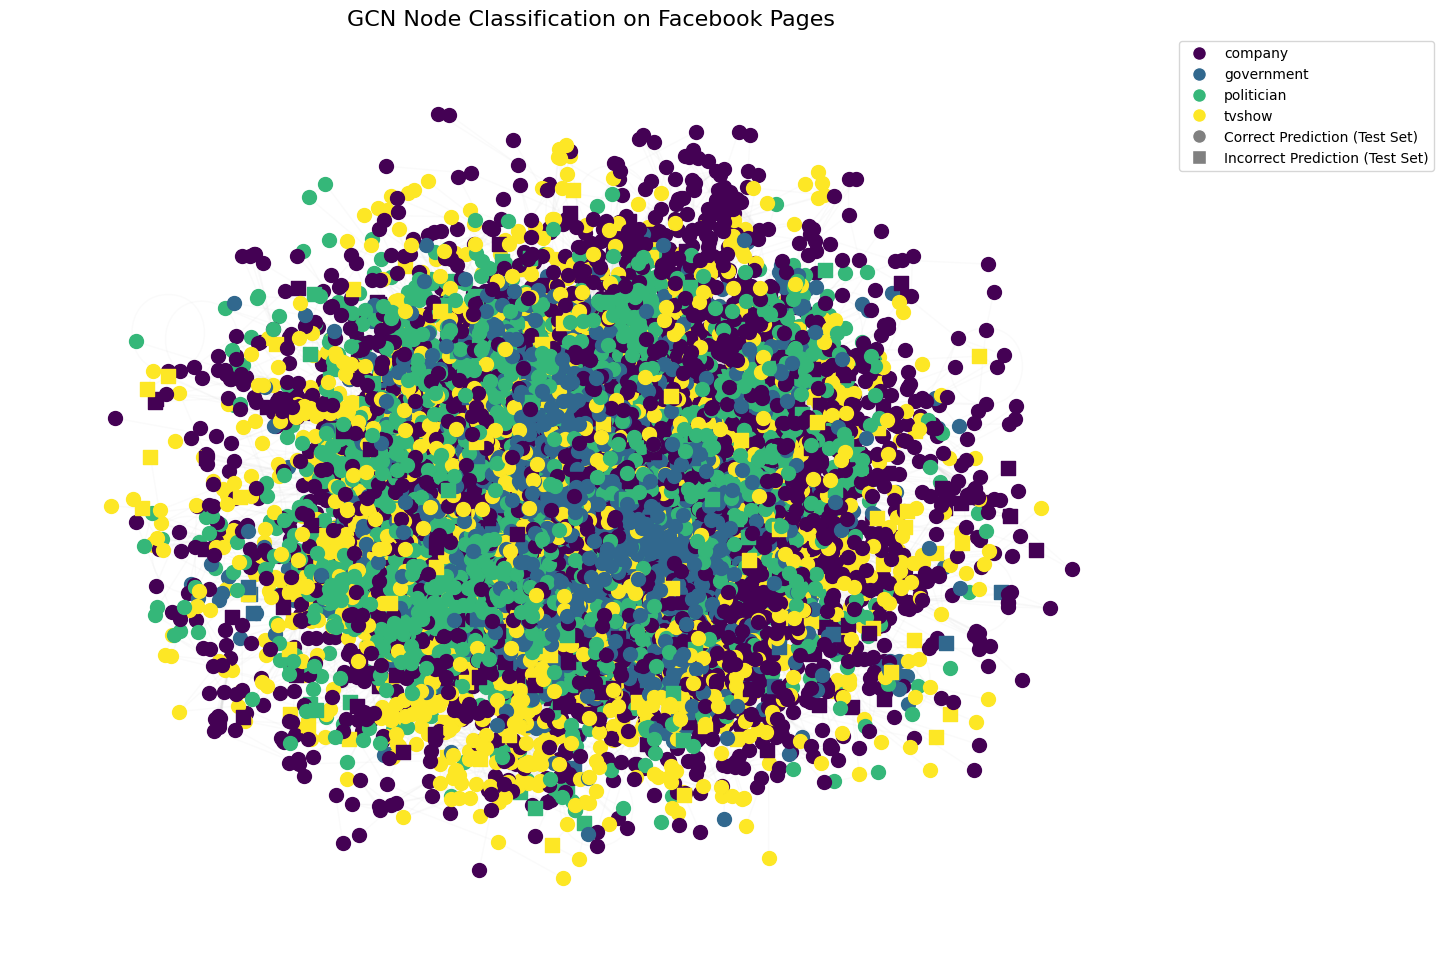

In [36]:
plt.figure(figsize=(15, 12))

# Draw nodes
for i, shape in enumerate(node_shapes):
    # Only draw nodes that are in the test set and have specific shapes 's' for incorrect
    # All other nodes (including correct test predictions) will be drawn as circles
    if test_nodes_mask_np[i] and shape == 's':
        nx.draw_networkx_nodes(G, pos, nodelist=[i], node_color=[node_colors[i]], node_shape=shape, node_size=100, ax=plt.gca())
    elif not test_nodes_mask_np[i] or (test_nodes_mask_np[i] and shape == 'o'): # All non-test nodes and correct test nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[i], node_color=[node_colors[i]], node_shape='o', node_size=100, ax=plt.gca())

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.1, ax=plt.gca())

plt.title("GCN Node Classification on Facebook Pages", fontsize=16)
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.axis('off')
plt.show()